In [18]:
import mglearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

決定木には2つの大きな長所がある  
1. 結果のモデルが可視化しやすいこと(小さい決定木であれば)。
2. それぞれの特徴量は独立して処理されるためスケールに対して完全に不変である。回帰で係数比較をするためにスケーリングする必要もないし、対数変換する必要もない。

決定木の欠点は過剰適合しやすいく、汎化性能が低い傾向があることだ。  
これについては次のアンサンブル学習で対応できる

# 決定木のアンサンブル学習

## ランダムフォレスト
- 個々の決定木は比較的うまく予測できているが、一部のデータで過剰適合してしまっているという考えに基づいて、それぞれ異なった方向に過剰適合した決定木をたくさん作りその結果の平均をとる事で過剰適合の度合いを減らすという手法  

多様性が重要となる。つまり似通った方向で過剰適合している木を寄せ集めてもよい予測にはならない

### ランダムフォレストの構築過程
**構築する決定木の数=学習器を選ぶ(ハイパーパラメータでいうn_estimators)。**  
これらの木がそれぞれ異なる木となるようにアルゴリズムが乱数的な選択を行う。  
1. まずはデータの抽出方法にブートスラップサンプリング(bootstrap sampling)を行う。これは**n_smaples個のデータから交換ありでn_samples個のデータを選び出す方法**である(つまり同じデータが何回も選ばれる可能性がある復元抽出)。
2. 次に1,で選ばれたデータセットを用いて決定木を作る。**ただし決定木を構築する特徴量をランダムに選びその特徴量の中から最適なテストを行い木を構築する。**これによって、個々のノードが異なる特徴量を持った決定木が出来る。特徴量サブセットの大きさはmax_featuresmで制御できる。  

#### この過程で重要なパラメータはmax_featuresである。
- max_featuresをn_featuresと同一にすると木を構築する特徴量のサブセットが同じになり、ランダムネスがなくなる。
- max_featuresを小さくすると、ランダムフォレストの決定木はそれぞれ異なるものになるが、決定木を深く作らないとデータに適合できない。

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (100, 2)
y shape: (100,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

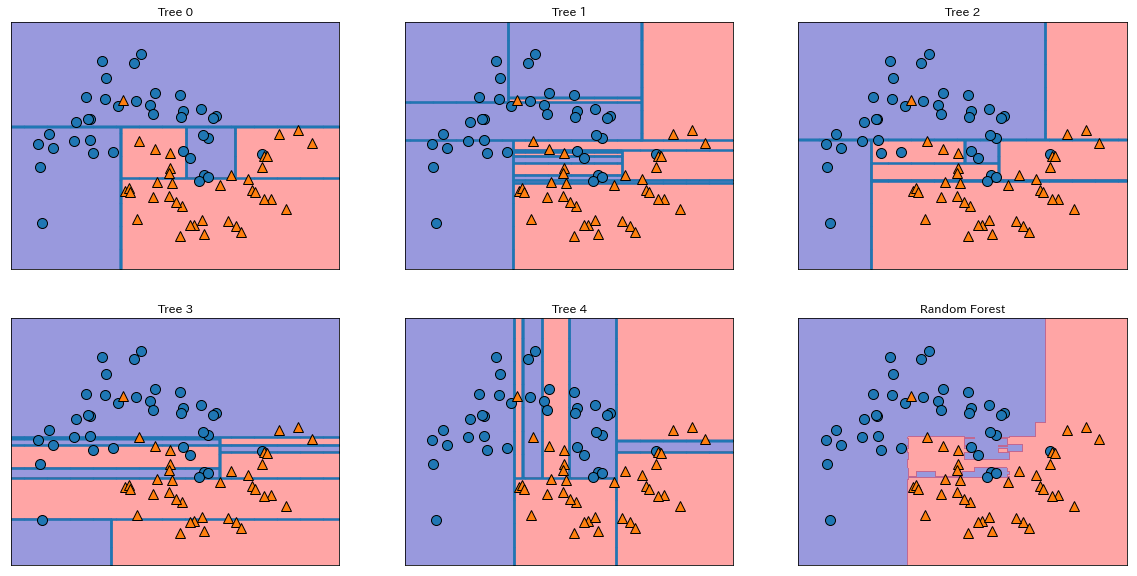

In [13]:
fig, axes = plt.subplots(2,3, figsize=(20,10))

for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title('Tree {}'.format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1,-1], alpha=.4)
axes[-1,-1].set_title('Random Forest')

mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

5つの決定木の決定境界がそれぞれ異なっていることがわかる。それぞれ決定木は一部のデータについて分類を失敗している。これはブートストラッピングの結果、ここに表示されている訓練セットに一部が学習する際のデータセットに含まれていなかったからである。
tree1,tree4で明らかに外れ値のようなオレンジの点が分類されているが、RandomForestでは水色として分類されている。

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [17]:
print('Accurancy on training set : {:,.3f}'.format(forest.score(X_train,y_train)))
print('Accurancy on training set : {:,.3f}'.format(forest.score(X_test,y_test)))

Accurancy on training set : 1.000
Accurancy on training set : 0.972


ランダムフォレストはハイパーパラメータチューニングしていないのにも関わらず、テストデータに対して97パーセントの精度を示した。これは線形モデルや個別の決定木モデルより精度が高い。ランダムフォレストは一般にデフォルトのパラメータでうまく機能する

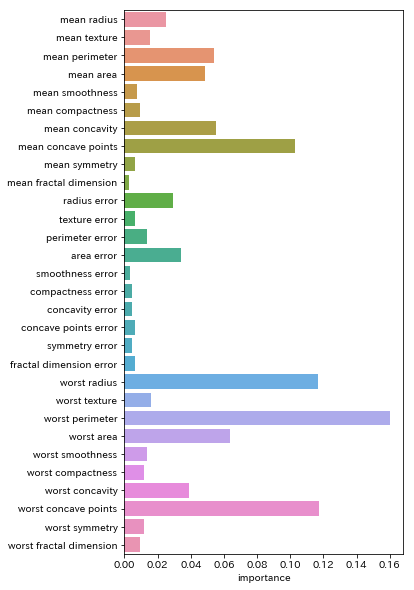

In [26]:
f_importance = pd.DataFrame(
    {'importance':forest.feature_importances_},
    index=cancer.feature_names
)
plt.figure(figsize=(5,10))
sns.barplot(x=f_importance.importance, y=f_importance.index, data=f_importance)

個別の決定木よりも、多くの特徴量に0以上の数値を与えている。ランダムフォレストを構築する際の乱数性によってアルゴリズムはより多くの特徴量を考慮して木を構築するので、個別の決定木の結果より広い視野で全体像をみることができるようになる。  
決定木が一つだと、すべての特徴量の中で最も判別が良い特徴量を一つずつ見ていくのに対して、それぞれの決定木で異なる特徴量で説明をしようとする

## まとめ
- RandomForestは決定木の弱点を補うことができる。デメリットとしては、個別の決定木よりもモデルの解釈がしづらくなることと学習により時間がかかることだ
- 調整するべきハイパーパラメータ
    - n_estimators:大きければ大きいほどよい。より多くの決定木の平均をとると、過剰適合が低減されてアンサンブルが頑健になる。
    - max_features:一般にデフォルト値を使うと良い。max_featuresが小さいと適合するのにdepthを増やさないと適合しなきなり、n_featuresと同一だと決定木のランダムネスがなくなる。分類ではmax_features=sqrt(n_features)で回帰ではmax_features=n_feturesとなっている。